In [ ]:
%pip install scikit-learn==1.5.2

In [62]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load in the XLK dataset.
xlk = pd.read_csv("../data/xlk_historical_data.csv").rename(columns={"Close/Last": "Price"})[["Date", "Price"]]

# Load in the industry network datasets.

# Energy sector.
crude_oil_futures = pd.read_csv("../data/crude_oil_futures_historical_data.csv")[["Date", "Price"]]
natural_gas_futures = pd.read_csv("../data/natural_gas_futures_historical_data.csv")[["Date", "Price"]]

# Metals sector.
copper_futures = pd.read_csv("../data/copper_futures_historical_data.csv")[["Date", "Price"]]
gold_futures = pd.read_csv("../data/gold_futures_historical_data.csv")[["Date", "Price"]]
silver_futures = pd.read_csv("../data/silver_futures_historical_data.csv")[["Date", "Price"]]

# Financial sector.
us_10_year_treasury_yield = pd.read_csv("../data/us_10_year_treasury_yield_historical_data.csv")[["Date", "Price"]]
federal_funds_rate = pd.read_csv("../data/federal_funds_rate_historical_data.csv")

# Consumer sentiment and macroindicators.
consumer_confidence_index = pd.read_csv("../data/consumer_confidence_index_historical_data.csv")[["Date", "Price"]]
us_dollar_index = pd.read_csv("../data/us_dollar_index_historical_data.csv")[["Date", "Price"]]

# Global economic indicators.
eur_usd_exchange_rate = pd.read_csv("../data/eur_usd_historical_data.csv")[["Date", "Price"]]
usd_cny_exchange_rate = pd.read_csv("../data/usd_cny_historical_data.csv")[["Date", "Price"]]

# Format data.
federal_funds_rate = federal_funds_rate.rename(
    columns=
    {
        "observation_date": "Date",
        "FEDFUNDS": "Federal_Funds_Rate"
    }
)

# Get `Month` and `Year` columns.
federal_funds_rate["Month"] = pd.to_datetime(federal_funds_rate["Date"]).dt.month
federal_funds_rate["Year"] = pd.to_datetime(federal_funds_rate["Date"]).dt.year

xlk["Month"] = pd.to_datetime(xlk["Date"]).dt.month
xlk["Year"] = pd.to_datetime(xlk["Date"]).dt.year

In [77]:
# Merge all of the data.
data = (
    xlk
    .merge(
        crude_oil_futures,
        on="Date",
        how="inner",
        suffixes=("", "_crude_oil_futures")
    )
    .merge(
        natural_gas_futures,
        on="Date",
        how="inner",
        suffixes=("", "_natural_gas_futures")
    )
    .merge(
        copper_futures,
        on="Date",
        how="inner",
        suffixes=("", "_copper_futures")
    )
    .merge(
        gold_futures,
        on="Date",
        how="inner",
        suffixes=("", "_gold_futures")
    )
    .merge(
        silver_futures,
        on="Date",
        how="inner",
        suffixes=("", "_silver_futures")
    )
    .merge(
        us_10_year_treasury_yield,
        on="Date",
        how="inner",
        suffixes=("", "_us_10_year_treasury_yield")
    )
    .merge(
        federal_funds_rate,
        on=["Month", "Year"],
        how="inner",
        suffixes=("", "_federal_funds_rate")
    )
    .merge(
        consumer_confidence_index,
        on="Date",
        how="inner",
        suffixes=("", "_consumer_confidence_index")
    )
    .merge(
        us_dollar_index,
        on="Date",
        how="inner",
        suffixes=("", "_us_dollar_index")
    )
    .merge(
        eur_usd_exchange_rate,
        on="Date",
        how="inner",
        suffixes=("", "_eur_usd_exchange_rate")
    )
    .merge(
        usd_cny_exchange_rate,
        on="Date",
        how="inner",
        suffixes=("", "_usd_cny_exchange_rate")
    )
    .drop(columns=["Month", "Year", "Date_federal_funds_rate"])
)

# Make the datetime column a date.
data["Date"] = pd.to_datetime(data["Date"])

# Clean the data.
data["Price_gold_futures"] = data["Price_gold_futures"].str.replace(",", "").astype(float)

# # Standardize the data.
# scaler = StandardScaler()
# data[data.drop(columns=["Date"]).columns] = scaler.fit_transform(data.drop(columns=["Date"]))

# Sort the data by date and set the index.
data = data.sort_values("Date")
data = data.set_index("Date")

# Add our lagged columns.
original_columns = data.columns
lags = [1, 3, 7, 30, 90]
for lag in lags:
    for col in original_columns:
        data[f"{col}_lag_{lag}"] = data[col].shift(lag)
data = data.dropna()

In [79]:
# Do correlation analysis for the lagged columns and `Price`.
lagged_columns = [col for col in data.columns if "lag" in col]
for col in lagged_columns:
    print(f"{col:<40} {data['Price'].corr(data[col]):.4f}")

Price_lag_1                              0.9995
Price_crude_oil_futures_lag_1            0.6397
Price_natural_gas_futures_lag_1          0.1925
Price_copper_futures_lag_1               0.8675
Price_gold_futures_lag_1                 0.9528
Price_silver_futures_lag_1               0.8760
Price_us_10_year_treasury_yield_lag_1    0.5014
Federal_Funds_Rate_lag_1                 0.6267
Price_consumer_confidence_index_lag_1    0.9498
Price_us_dollar_index_lag_1              0.4689
Price_eur_usd_exchange_rate_lag_1        -0.2337
Price_usd_cny_exchange_rate_lag_1        0.4507
Price_lag_3                              0.9985
Price_crude_oil_futures_lag_3            0.6376
Price_natural_gas_futures_lag_3          0.1894
Price_copper_futures_lag_3               0.8666
Price_gold_futures_lag_3                 0.9528
Price_silver_futures_lag_3               0.8752
Price_us_10_year_treasury_yield_lag_3    0.4990
Federal_Funds_Rate_lag_3                 0.6270
Price_consumer_confidence_index_lag_3  

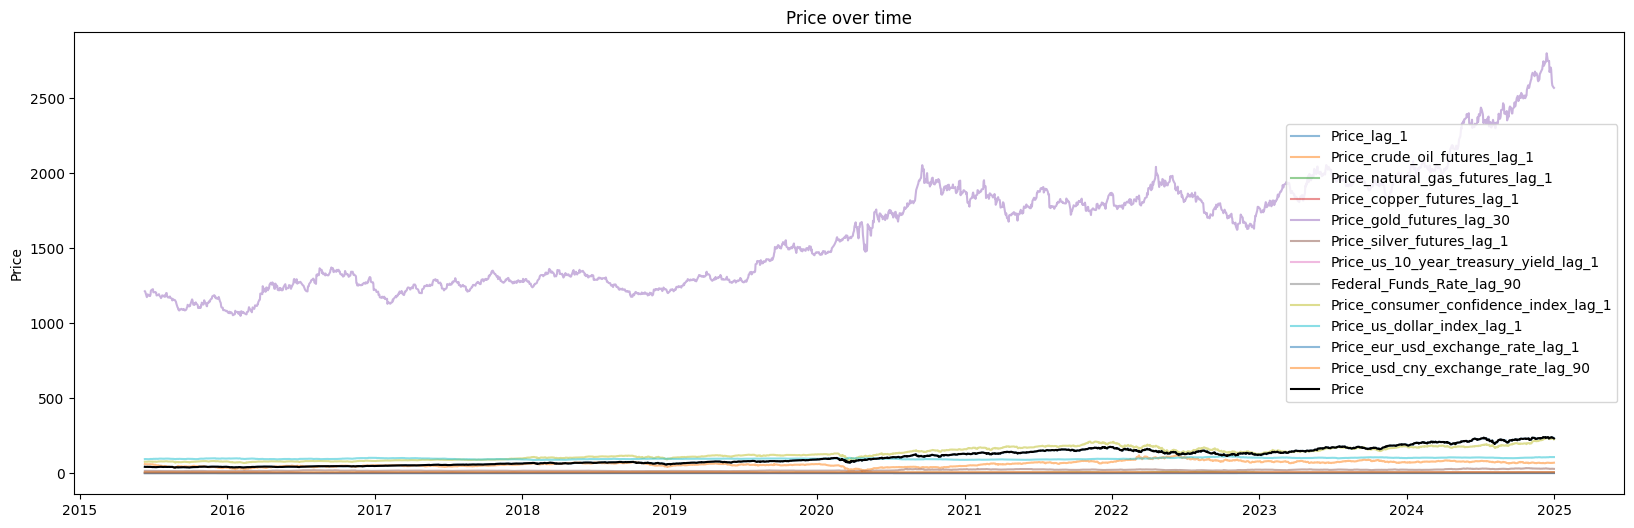

In [80]:
# Manually selecting the best amount of lag for each feature.
best_lags = [
    "Price_lag_1",
    "Price_crude_oil_futures_lag_1",
    "Price_natural_gas_futures_lag_1",
    "Price_copper_futures_lag_1",
    "Price_gold_futures_lag_30",
    "Price_silver_futures_lag_1",
    "Price_us_10_year_treasury_yield_lag_1",
    "Federal_Funds_Rate_lag_90",
    "Price_consumer_confidence_index_lag_1",
    "Price_us_dollar_index_lag_1",
    "Price_eur_usd_exchange_rate_lag_1",
    "Price_usd_cny_exchange_rate_lag_90"
]

# Plot the data.
plt.figure(figsize=(20, 6))
for col in best_lags:
    plt.plot(data[col], label=col, alpha=0.5)
plt.plot(data["Price"], label="Price", color="black")
plt.legend()
plt.title("Price over time")
plt.ylabel("Price")
plt.show()

In [81]:
# Define our `Lasso`.
lasso = Lasso()

# Define our `X` and `y`.
X, y = data[best_lags].drop("Price_lag_1", axis=1), data["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

gsc = GridSearchCV(
    estimator = lasso,
    param_grid = {
        'alpha': np.arange(0.01, 1, 0.01),
    },
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

# Fit `gsc`.
gsc.fit(X_train, y_train)
best_model = gsc.best_estimator_

y_train_true = y_train * scaler.scale_[0] + scaler.mean_[0]
y_train_pred = pd.Series(best_model.predict(X_train) * scaler.scale_[0] + scaler.mean_[0], index=y_train.index)

y_test_true = y_test * scaler.scale_[0] + scaler.mean_[0]
y_test_pred = pd.Series(best_model.predict(X_test) * scaler.scale_[0] + scaler.mean_[0], index=y_test.index)

print("Train R^2:", r2_score(y_train_true, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train_true, y_train_pred))
print("Train RMSE:", root_mean_squared_error(y_train_true, y_train_pred))
print()
print("Test R^2:", r2_score(y_test_true, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test_true, y_test_pred))
print("Test RMSE:", root_mean_squared_error(y_test_true, y_test_pred))

Train R^2: 0.9854715555087655
Train MAE: 197.82360969519272
Train RMSE: 266.4741689622687

Test R^2: -0.22776812015301773
Test MAE: 1727.3772184594034
Test RMSE: 1858.4810050955784


In [82]:
# Define our `Lasso`.
ridge = Ridge()

# Define our `X` and `y`.
X, y = data[best_lags].drop("Price_lag_1", axis=1), data["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

gsc = GridSearchCV(
    estimator = ridge,
    param_grid = {
        'alpha': np.arange(0.01, 1, 0.01),
    },
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

# Fit `gsc`.
gsc.fit(X_train, y_train)
best_model = gsc.best_estimator_

y_train_true = y_train * scaler.scale_[0] + scaler.mean_[0]
y_train_pred = pd.Series(best_model.predict(X_train) * scaler.scale_[0] + scaler.mean_[0], index=y_train.index)

y_test_true = y_test * scaler.scale_[0] + scaler.mean_[0]
y_test_pred = pd.Series(best_model.predict(X_test) * scaler.scale_[0] + scaler.mean_[0], index=y_test.index)

print("Train R^2:", r2_score(y_train_true, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train_true, y_train_pred))
print("Train RMSE:", root_mean_squared_error(y_train_true, y_train_pred))
print()
print("Test R^2:", r2_score(y_test_true, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test_true, y_test_pred))
print("Test RMSE:", root_mean_squared_error(y_test_true, y_test_pred))

Train R^2: 0.9894963068047068
Train MAE: 166.99467328991287
Train RMSE: 226.57739075499404

Test R^2: -0.18201515274247848
Test MAE: 1690.0035056337963
Test RMSE: 1823.5239532726107


In [91]:
# Define our `LinearRegression`.
lr = LinearRegression()

# Define our `X` and `y`.
X, y = data[best_lags].drop("Price_lag_1", axis=1), data["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit `lr`.
lr.fit(X_train, y_train)

y_train_true = y_train 
y_train_pred = pd.Series(lr.predict(X_train), index=y_train.index)

y_test_true = y_test
y_test_pred = pd.Series(lr.predict(X_test), index=y_test.index)

print("Train R^2:", r2_score(y_train_true, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train_true, y_train_pred))
print("Train RMSE:", root_mean_squared_error(y_train_true, y_train_pred))
print()
print("Test R^2:", r2_score(y_test_true, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test_true, y_test_pred))
print("Test RMSE:", root_mean_squared_error(y_test_true, y_test_pred))

Train R^2: 0.9894986563271517
Train MAE: 2.9702694703492996
Train RMSE: 4.035427057162709

Test R^2: -0.20052814345383974
Test MAE: 30.36626660542896
Test RMSE: 32.73464471534834


In [95]:
list(zip(lr.feature_names_in_, [float(val) for val in lr.coef_]))

[('Price_crude_oil_futures_lag_1', -0.07543568169507624),
 ('Price_natural_gas_futures_lag_1', 0.21532503211530946),
 ('Price_copper_futures_lag_1', 10.556010226667789),
 ('Price_gold_futures_lag_30', 0.02936971122073483),
 ('Price_silver_futures_lag_1', -0.04212306904030218),
 ('Price_us_10_year_treasury_yield_lag_1', -3.1243674365956386),
 ('Federal_Funds_Rate_lag_90', 1.3490410923919165),
 ('Price_consumer_confidence_index_lag_1', 0.6814536313066137),
 ('Price_us_dollar_index_lag_1', 2.143392439640806),
 ('Price_eur_usd_exchange_rate_lag_1', 92.01670635751728),
 ('Price_usd_cny_exchange_rate_lag_90', -5.636818255731936)]

In [97]:
X.std()

Price_crude_oil_futures_lag_1             17.704407
Price_natural_gas_futures_lag_1            1.424541
Price_copper_futures_lag_1                 0.787624
Price_gold_futures_lag_30                378.038827
Price_silver_futures_lag_1                 4.842423
Price_us_10_year_treasury_yield_lag_1      1.073903
Federal_Funds_Rate_lag_90                  1.805798
Price_consumer_confidence_index_lag_1     40.185870
Price_us_dollar_index_lag_1                4.969881
Price_eur_usd_exchange_rate_lag_1          0.052928
Price_usd_cny_exchange_rate_lag_90         0.308424
dtype: float64